In [207]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os

import pandas as pd
import numpy as np
from numba import jit, njit, prange, set_num_threads
from scipy.spatial.transform import Rotation as rot
try:
    from cupyx.scipy.ndimage import zoom
    import cupy as cp
    from numba import cuda 
    has_gpu = True
    print('CUDA GPU detected, using CUDA for some calculations')
except:
    from scipy.ndimage import zoom
    has_gpu = False

import astropy.units as u
from astropy.visualization import quantity_support

quantity_support()

%matplotlib widget

figsize=(12,7)

set_num_threads(10)

CUDA GPU detected, using CUDA for some calculations


In [208]:
@njit(parallel=True)
def circ_mask(image_w, image_h, N_side, center, radius):
    x_res = image_w / N_side
    y_res = image_h / N_side
    src = np.ones((N_side, N_side))
    for i in prange(N_side):
        for j in prange(N_side):
            if np.sqrt((i * x_res - center[0])**2 + (j * y_res - center[1])**2) > radius:
                src[i][j] = 0
    return src

In [209]:
## Parse Zemax output files

### Input source parameters

# mapping of surface number to name
surf_number_to_name = {
    0: 'Beam origin',
    11: 'Zotefoam',
    16: 'p2',
    20: 'raft_obsc',
    24: 'p1',
    27: 'f1',
    31: 'k3',
    34: 'k2',
    37: 'k1',
    39: 'flange',
    40: 'cabin floor',
}
surf_name_to_number = {
    'Beam origin': 0,
    'Zotefoam': 11,
    'p2': 16,
    'raft_obsc': 20,
    'p1': 24,
    'f1': 27,
    'k3': 31,
    'k2': 34,
    'k1': 37,
    'flange': 39,
    'cabin floor': 40,
}

In [210]:
src_surf_name = 'k2'
# crop factor
src_zoom = 3
# more points more better
src_upsample = 2

dest_surf_name = 'k1'
# more points more better
dest_upsample = 1.5

# K-mirror configuration:
# 3: 0deg
# 5: 45deg toward computer rack
config = 5
# Feed configuration:
# Choose from 8/16 feeds to launch beams from. in config 3, all beams exit invar ring along y-axis.
# Numbering is closest in to farthest out, alternating +y, -y.
# 1: beam exits ceiling near center of invar ring, just to -y side along global y-axis
# 8: beam exits ceiling near +y side of invar ring, along global y-axis.
field = 1

Parsing amp/phase data...
(512, 512)


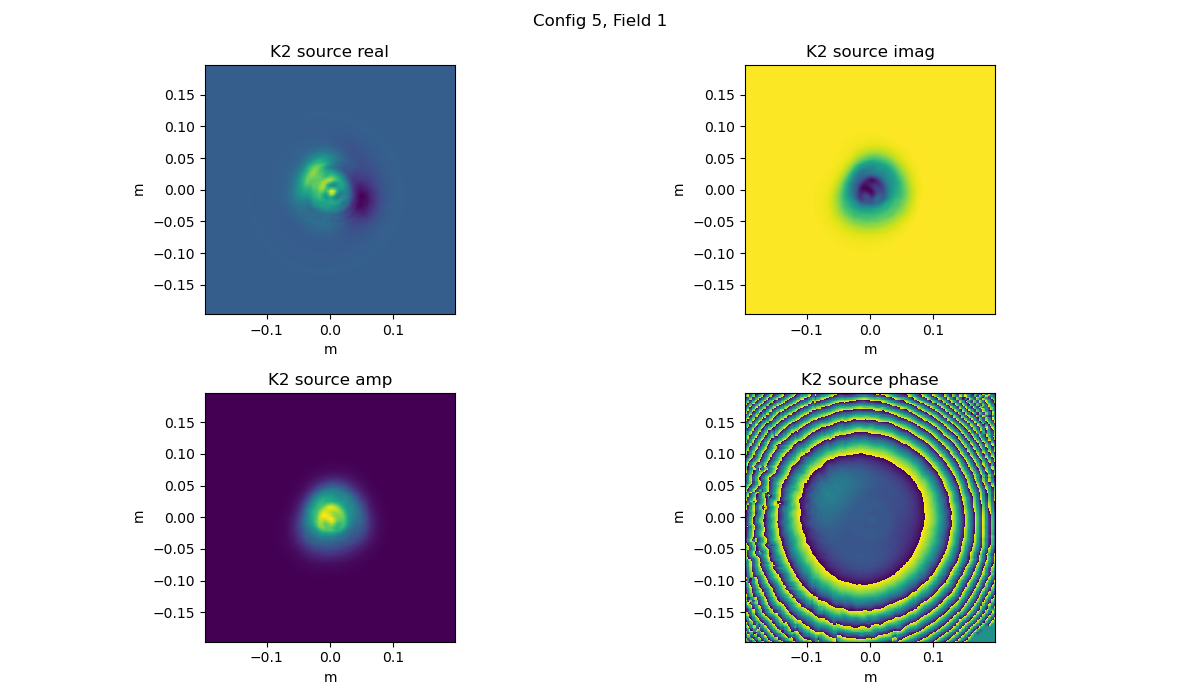

In [211]:
# irradiance and phase data from POP beamfiles to a surface are output as arrays in a plane
# propagating along the chief ray, with x,y axes perpendicular to it with some rotation.
# The POP simulation starts at the same point every time, and terminates on a given surface.
# From this surface, we export the POP data as a text file.
# We take this text file as the illumination for the next surface.
# direc = f'/home/evanmayer/TIME_data/mirror_mapping/zemax/pop_system/config_{config}/field_{field}/'
# direc = rf'\\evanpi\shared\scratch\TIME_data\config_{config}\field_{field}\\'
direc = r'C:\Users\User\Documents\scratch\TIME_data\config_5\field_1\\'
amp_file = src_surf_name + '_launch_irr.txt'
phase_file = src_surf_name + '_launch_phase.txt'
src_amp = np.genfromtxt(direc + amp_file, skip_header=15, encoding='utf-16')
src_phase = np.genfromtxt(direc + phase_file, skip_header=15, encoding='utf-16')
src = src_amp * np.cos(src_phase) + 1j * src_amp * np.sin(src_phase)

lambda_query = "Beam wavelength is "
shape_query = "Display X "
with open(direc + amp_file, encoding='utf-16') as f:
    print('Parsing amp/phase data...')
    for line in f.readlines():
        if line.startswith(lambda_query):
            lambd = float(line.lstrip(lambda_query).split()[0])
        if line.startswith(shape_query):
            parts = line.lstrip(shape_query).split()
            src_width = float(parts[2].rstrip(','))
            src_height = float(parts[-2].rstrip(','))
lambd = (lambd * u.micron).to(u.m)
src_width = (src_width * u.mm).to(u.m)
src_height = (src_height * u.mm).to(u.m)

# DANGER, WILL ROBINSON
# src = circ_mask(src_width, src_height, src.shape[0], (src_width / 2., src_height / 2.), src_width / 16.)

# do any upsampling
if has_gpu:
    src = cp.asnumpy(zoom(cp.array(src), src_zoom * src_upsample, order=1))
else:
    src = zoom(src, src_zoom * src_upsample, order=1)
# crop down to original size
center_x, center_y = (src.shape[0] // 2, src.shape[1] // 2)
bbox_xmin, bbox_xmax = center_x + np.array([-src.shape[0] // src_zoom // 2, src.shape[0] // src_zoom // 2])
bbox_ymin, bbox_ymax = center_y + np.array([-src.shape[1] // src_zoom // 2, src.shape[1] // src_zoom // 2])
src = src[bbox_xmin:bbox_xmax, bbox_ymin:bbox_ymax]

print(src.shape)

assert(src.shape[0] == src.shape[1]), "Non-square input data!"
N = src.shape[0]

xs = np.linspace(-src_width / src_zoom / 2, src_width / src_zoom / 2, N)
ys = np.linspace(-src_height / src_zoom / 2, src_height / src_zoom / 2, N)
xx, yy = np.meshgrid(xs, ys)
zz = np.zeros_like(xx)

fig, ax = plt.subplots(figsize=figsize, nrows=2, ncols=2)
ax[0,0].pcolormesh(xx, yy, (src.real))
ax[0,0].set_aspect('equal')
ax[0,0].set_title(f'{src_surf_name.upper()} source real')
ax[0,1].pcolormesh(xx, yy, (src.imag))
ax[0,1].set_aspect('equal')
ax[0,1].set_title(f'{src_surf_name.upper()} source imag')

ax[1,0].pcolormesh(xx, yy, np.abs(src))
ax[1,0].set_aspect('equal')
ax[1,0].set_title(f'{src_surf_name.upper()} source amp')
ax[1,1].pcolormesh(xx, yy, np.angle(src))
ax[1,1].set_aspect('equal')
ax[1,1].set_title(f'{src_surf_name.upper()} source phase')
fig.suptitle(f'Config {config}, Field {field}')
fig.tight_layout()

In [212]:
### Construct the location of each source point in the frame of the beamfile
 
xx_f = xx.flatten()
yy_f = yy.flatten()
zz_f = zz.flatten()
src_coords = np.vstack([xx_f, yy_f, zz_f]).T

Parsing sag data...
dz shape: 0.64 m 0.64 m (387, 387)


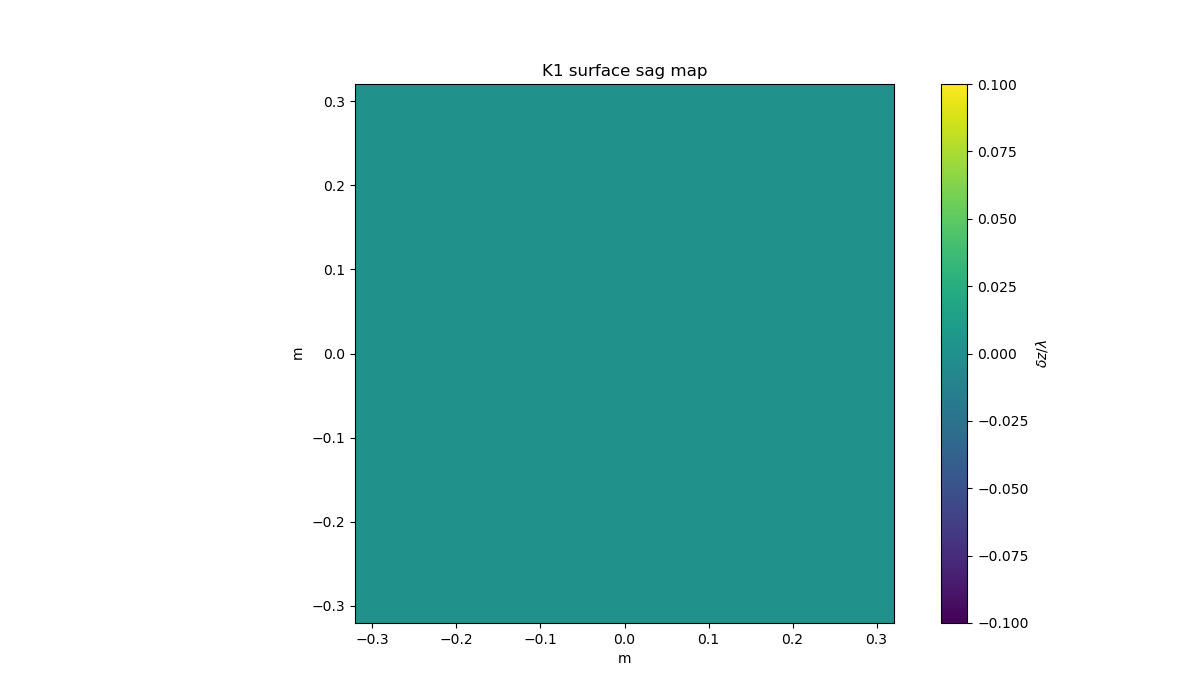

In [213]:
### Load in sag data

# If a surface has some curvature, we can export it as a text file from the surface's sag report.
sag_file = dest_surf_name + '_sag.txt'
if os.path.exists(direc + sag_file):
    print('Parsing sag data...')
    # parse sag array from file
    dz = (np.genfromtxt(direc + sag_file, skip_header=15, encoding='utf-16') * u.mm).to(u.m)
    assert(dz.shape[0] == dz.shape[1]), "Non-square sag data!"
    # parse optic shape from file
    width_query = "Width = "
    with open(direc + sag_file, encoding='utf-16') as f:
        for line in f.readlines():
            if line.startswith(width_query):
                sag_width = float(line.lstrip(width_query).split(',')[0])
                break
    sag_width = (sag_width * u.mm).to(u.m)
    sag_height = sag_width
elif dest_surf_name == 'f1':
    sag_width = (18.110 * u.imperial.inch).to(u.m)
    sag_height = (31.496 * u.imperial.inch).to(u.m)
    dz = np.zeros((129,129)) * u.m
elif dest_surf_name == 'k3':
    sag_width = (21.654 * u.imperial.inch).to(u.m)
    sag_height = (29.528 * u.imperial.inch).to(u.m)
    dz = np.zeros((129,129)) * u.m
elif dest_surf_name == 'k1':
    sag_width = (18.110 * u.imperial.inch).to(u.m)
    sag_height = (23.622 * u.imperial.inch).to(u.m)
    dz = np.zeros((129,129)) * u.m
elif dest_surf_name == 'flange':
    sag_width = .5 *u.m
    sag_height = sag_width
    dz = np.zeros((129,129)) * u.m
else:
    dz = 0

dz_min = dz.min()
dz_max = dz.max()

# up/downsample dest surface
if has_gpu:
    dz = cp.asnumpy(zoom(cp.array(dz.value), src_zoom)) * u.m
else:
    dz = zoom(dz, dest_upsample) * u.m

print('dz shape:', sag_width, sag_height, dz.shape)

# fiducial: (0,0) dimple in dz
dz[0][0] += 0.1 * u.m

N_img = dz.shape[0]

xs_img = np.linspace(-sag_width / 2, sag_width / 2, N_img)
ys_img = np.linspace(-sag_height / 2, sag_height / 2, N_img)
xx_img, yy_img = np.meshgrid(xs_img, ys_img)

fig, ax = plt.subplots(figsize=figsize)
im = ax.pcolormesh(xx_img, yy_img, (dz / lambd).decompose(), vmin=dz_min / lambd, vmax=dz_max / lambd)
ax.set_title(f'{dest_surf_name.upper()} surface sag map')
ax.set_aspect('equal')
fig.colorbar(im, ax=ax, label='$\delta z / \lambda$')

In [214]:
### Construct the location of each field point in the frame of the mirror

xx_img_f = xx_img.flatten()
yy_img_f = yy_img.flatten()
dz_f = dz.flatten()
dest_coords = np.vstack([xx_img_f, yy_img_f, dz_f]).T

In [215]:
### Parse a single ray trace to get chief ray data

# Arbitrary field, with zeroed normalized pupil coordinates Px=0, Py=0 gives CR.

# in order to place the source planes correctly, we must know the global location of the chief ray striking each surface.
chief_ray_skiplines = 50
nrows=49
chief_ray_coords = pd.read_csv(direc + 'chief_ray_trace.txt', encoding='utf-16', skiprows=chief_ray_skiplines, delim_whitespace=True, nrows=nrows, header=21)

In [216]:
### Parse POP propagation report

# Get rotation matrices of beam axes relative to surface local axes.

# Get position offset of beam file coordinate system origin from chief ray.

# The top of the file lists the x,y,z offsets of the beam file coordinate system origin
# from the chief ray strike at each surface. It also lists the direction cosines.
nrows = 38
header = 7
# k1 has everything from origin to k1
beamfile_chief_ray_offsets = pd.read_csv(direc + 'k1' + '_launch_prop_report.txt', encoding='utf-16', delim_whitespace=True, nrows=nrows, header=header)

In [217]:
# The POP propagation report then tells us how the POP matrix axes are rotated as it
# bounces from surface to surface.
# At each surface, the POP matrix axes are perpendicular to the chief ray,
# so there is one rotation matrix for before the beam hits the surface, and one for
# after it hits the surface and has the surface's transfer matrix applied to it.
# We take as source radiation input the "after" orientation of the surface
# immediately preceding our destination surface of interest.
beamfile_matrices = {}
surf_query = 'Surface transfer from before'
surf_num = -1
mat = []
togo = -1
with open(direc + src_surf_name + '_launch_prop_report.txt', encoding='utf-16') as f:
    for line in f.readlines():
        if line.startswith(surf_query):
            s = line.lstrip(surf_query)
            slist = s.split()
            surf_num = int(slist[-1])
        if line.startswith('Orientation matrix'):
            mat = []
            togo = 4
        if togo < 4 and togo > 0:
            mat.append([float(s) for s in line.lstrip().split()])
        elif togo == 0:
            if surf_num not in beamfile_matrices.keys():
                beamfile_matrices[surf_num] = [np.array(mat)] # "Before" matrix
            else:
                beamfile_matrices[surf_num].append(np.array(mat)) # "After" matrix
        togo -= 1

In [218]:
### Parse system prescription file report

# In order to get rotation matrices of surface local axes relative to global frame.

# The system prescription report gives us the rotation matrices and locations
# of each surface relative to whichever surface we have defined as the
# global origin.
global_matrices = {}
global_section_start_query = 'GLOBAL VERTEX COORDINATES, ORIENTATIONS, AND ROTATION/OFFSET MATRICES:'
global_section_end_query = 'GLOBAL SURFACE CENTER OF CURVATURE POINTS:'
global_section_skiplines = 7
surf_num = 0
mat = []
togo = -1
with open(direc + 'system_prescription.txt', encoding='utf-16') as f:
    # Skip all lines until we get to the global rotation matrix section.
    while global_section_start_query not in line:
        line = f.readline()
        continue
    # Skip until matrices start
    while global_section_skiplines:
        global_section_skiplines -= 1
        line = f.readline()
    # Read each matrix
    while global_section_end_query not in line:
        if not line.rstrip(): # skip empty lines between matrices
            line = f.readline()
            continue
        slist = line.split()
        if 5 < len(slist): # a line with a surface number, and maybe a label
            surf_num = int(slist[0])
            matline = slist[1:4]
            mat = []
            togo = 2
        else: # just matrix data
            matline = slist[:3]
        assert len(matline) == 3
        mat.append([float(val) for val in matline])
        if togo == 2:
            x = float(slist[4])
        elif togo == 1:
            y = float(slist[3])
        elif togo == 0: # save off matrix
            z = float(slist[3])
            global_matrices[surf_num] = [np.array(mat), (np.array([x,y,z]) * u.mm).to(u.m)]
        togo -= 1
        line = f.readline()

In [219]:
def plot_important_surfaces(global_matrices, surf_number_to_name):
    sz = .3
    first_time = True
    fig, ax = plt.subplots(figsize=(10,10), nrows=1, ncols=1, subplot_kw={'projection':'3d'})
    for key in global_matrices.keys():
        if key in surf_number_to_name.keys():
            if first_time: # don't spam legends
                leg_mod = ''
            else:
                leg_mod = '_'
            ax.quiver3D(
                global_matrices[key][1][0],
                global_matrices[key][1][1],
                global_matrices[key][1][2],
                sz * global_matrices[key][0][0,0],
                sz * global_matrices[key][0][1,0],
                sz * global_matrices[key][0][2,0],
                color='red',
                label=leg_mod + 'Local x'
            )
            ax.quiver3D(
                global_matrices[key][1][0],
                global_matrices[key][1][1],
                global_matrices[key][1][2],
                sz * global_matrices[key][0][0,1],
                sz * global_matrices[key][0][1,1],
                sz * global_matrices[key][0][2,1],
                color='green',
                label=leg_mod + 'Local y'
            )
            ax.quiver3D(
                global_matrices[key][1][0],
                global_matrices[key][1][1],
                global_matrices[key][1][2],
                sz * global_matrices[key][0][0,2],
                sz * global_matrices[key][0][1,2],
                sz * global_matrices[key][0][2,2],
                color='blue',
                label=leg_mod + 'Local z'
            )
            ax.text(
                global_matrices[key][1][0].value,
                global_matrices[key][1][1].value,
                global_matrices[key][1][2].value,
                surf_number_to_name[key] + f' ({key})',
                fontsize=8
            )
            if first_time:
                first_time = False
    ax.legend(loc='best')

    ax.set_proj_type('ortho')
    ax.set_title('Surface Local Frames in Global Coordinates')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('z (m)')

    vbox_size = 3
    ax.set_xlim(-vbox_size / 2, vbox_size / 2)
    ax.set_ylim(-vbox_size / 2, vbox_size / 2)
    ax.set_zlim(np.array([-vbox_size / 2, vbox_size / 2]) + 1)
    ax.set_box_aspect([1,1,1])
    ax.view_init(azim=-160, elev=-160.)

    fig.suptitle(f'Config {config}, Field {field}')
    fig.tight_layout()

    return fig, ax

In [220]:
### Transform destination points into global frame points

# destination
dest_surf = surf_name_to_number[dest_surf_name]
# transform from surface local frame to global frame
R_global_to_local_dest = rot.from_matrix(global_matrices[dest_surf][0].T)
R_local_to_global_dest = R_global_to_local_dest.inv()
# mirror surface coordinates in global frame
dest_prime = R_local_to_global_dest.apply(dest_coords) * u.m + global_matrices[dest_surf][1]

In [221]:
### Transform source plane points into global frame points

# source: beam data from after interacting with surface
src_surf = surf_name_to_number[src_surf_name]

# transform from surface local frame to global frame
R_global_to_local_src = rot.from_matrix(global_matrices[src_surf][0].T)
R_local_to_global_src = R_global_to_local_src.inv()

R_local_to_beam = rot.from_matrix(beamfile_matrices[src_surf][1]) # 1-index is beam matrix orientation after hitting src surface
R_beam_to_local_src = R_local_to_beam#.inv()
# operator that transforms a vector from beam frame to global frame
R_beam_to_global = R_local_to_global_src * R_beam_to_local_src

# Source planes are placed with some offset relative to the chief ray in the 
# local coordinate system, not necessarily at the global location of the optic's
# coordinate system.
# Calc the the beamfile offset from the chief ray in the global frame
beamfile_cr_offset = (beamfile_chief_ray_offsets[['X', 'Y', 'Z']].loc[src_surf].values * u.mm).to(u.m)
global_cr_offset = R_local_to_global_src.apply(beamfile_cr_offset) * u.m

# Calc location of the chief ray strike in the global frame
global_cr_pos = (chief_ray_coords[['X-coordinate', 'Y-coordinate', 'Z-coordinate']].loc[src_surf].values * u.mm).to(u.m)

global_beamfile_pos = global_cr_offset + global_cr_pos
src_prime = R_beam_to_global.apply(src_coords) * u.m + global_beamfile_pos

C:\Users\User\AppData\Local\Temp\ipykernel_10132\2958528451.py:10: RuntimeWarning: divide by zero encountered in log10
  c=np.log10(src)[::stride,::stride],
c:\Users\User\miniconda3\envs\gpu-astr\lib\site-packages\matplotlib\axes\_axes.py:4192: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


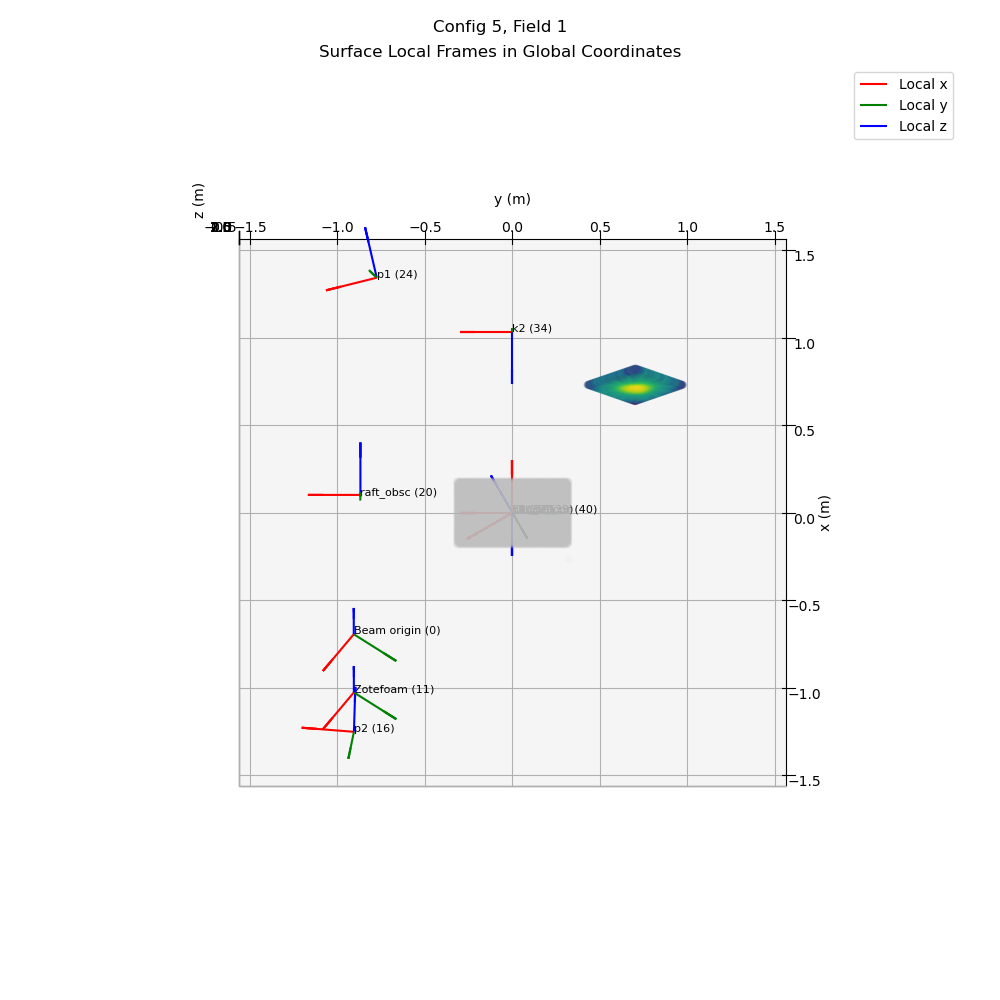

In [222]:
fig, ax = plot_important_surfaces(global_matrices, surf_number_to_name)
ax.view_init(elev=-90., azim=0.)
stride = 4
src_prime_grid = src_prime.reshape((xx.shape[0], xx.shape[1], 3))
dest_prime_grid = dest_prime.reshape((xx_img.shape[0], xx_img.shape[1], 3))
ax.scatter(
    src_prime_grid[::stride, ::stride, 0],
    src_prime_grid[::stride, ::stride, 1],
    src_prime_grid[::stride, ::stride, 2],
    c=np.log10(src)[::stride,::stride],
    alpha=0.05,
)
ax.scatter(
    dest_prime_grid[::stride, ::stride, 0],
    dest_prime_grid[::stride, ::stride, 1],
    dest_prime_grid[::stride, ::stride, 2],
    c='silver',
    alpha=0.05,
)

In [223]:
## Calculate Fresnel Integral

@jit(parallel=True, nopython=True)
def E_fresnel(src, src_pts, pts, lambd):
    '''
    Calculate the Fresnel diffraction integral.
    
    The source field E(x',y',z') is stored in array src, the resulting diffracted field
    is calculated at each (x,y,z) point in array pts.

    Parameters
    ----------
    src : np.ndarray
        Source plane data, flattened
    src_pts : np.ndarray
        (N,3) array of x,y,z, points in the global frame on which lie the complex source data
    pts : np.ndarray
        (N,3) array of x,y,z, points in the global frame at which to calculate the diffraction integral
    lambd : float
        Operating wavelength, m

    Returns
    -------
    np.ndarray
        Fresnel diffraction pattern evaluated at pts
    '''
    A = 1. / (1j * lambd)
    k = 2. * np.pi / lambd
    e_fresnel = np.zeros(pts.shape[0], dtype=np.complex64)
    # assumption: beam file pixels are square
    # side length = distance between adjacent points, d = sqrt((x'-x)^2 + (y'-y)^2 + (z'-z)^2)
    # area = (d)^2
    src_area_element = (
        (src_pts[1][0] - src_pts[0][0]) ** 2. +
        (src_pts[1][1] - src_pts[0][1]) ** 2. +
        (src_pts[1][2] - src_pts[0][2]) ** 2.
    )
    # for each point in the field
    for i in prange(len(pts)):
        x_dest, y_dest, z_dest = pts[i]
        # perform the fresnel integral over all source-field pairs
        res = np.zeros((src.shape[0]), dtype=np.complex64)
        for j in prange(src.shape[0]):
            x_src = src_pts[j][0]
            y_src = src_pts[j][1]
            z_src = src_pts[j][2]
            r2 = (
                (x_dest - x_src) * (x_dest - x_src) +
                (y_dest - y_src) * (y_dest - y_src) +
                (z_dest - z_src) * (z_dest - z_src)
            )
            r = r2 ** .5
            res[j] = src[j] * np.exp(1j * k * r) * (z_dest - z_src) / r2
        e_fresnel[i] = res.sum() # Riemann sum: \sum f(x,y) * dx * dy
    return A * e_fresnel * src_area_element


def E_fresnel_cuda(src, src_pts, pts, lambd):
    src = cp.asarray(src)
    src_pts = cp.asarray(src_pts)
    pts = cp.asarray(pts)

    A = 1. / (1j * lambd)
    k = 2. * np.pi / lambd
    e_fresnel = cp.zeros(pts.shape[0], dtype=np.complex64)
    # assumption: beam file pixels are square
    # side length = distance between adjacent points, d = sqrt((x'-x)^2 + (y'-y)^2 + (z'-z)^2)
    # area = (d)^2
    src_area_element = (
        (src_pts[1][0] - src_pts[0][0]) ** 2. +
        (src_pts[1][1] - src_pts[0][1]) ** 2. +
        (src_pts[1][2] - src_pts[0][2]) ** 2.
    )
    # for each point in the field
    for i in range(len(pts)):
        x_dest, y_dest, z_dest = pts[i]
        # perform the fresnel integral over all source-field pairs
        r2 = (
            (x_dest - src_pts[:,0]) * (x_dest - src_pts[:,0]) +
            (y_dest - src_pts[:,1]) * (y_dest - src_pts[:,1]) +
            (z_dest - src_pts[:,2]) * (z_dest - src_pts[:,2])
        )
        r = r2 ** .5
        res = src * cp.exp(1j * k.value * r) * (z_dest - src_pts[:,2]) / r2
        e_fresnel[i] = res.sum() # Riemann sum: \sum f(x,y) * dx * dy
    return A.value * e_fresnel * src_area_element

In [224]:
%%time

print(f'dimensionality: {dest_prime.shape[0] * src.shape[0] * src.shape[1]:,}')

# if not os.path.exists(src_surf_name.upper() + '_to_' + dest_surf_name.upper() + f'_config_{config}_field_{field}_results.npz'):
if has_gpu:
    fresnel_img_list = cp.asnumpy(E_fresnel_cuda(src.flatten(), src_prime, dest_prime, lambd))
else:
    fresnel_img_list = E_fresnel(src.flatten(), src_prime, dest_prime, lambd)

fresnel_img = fresnel_img_list.reshape(xx_img.shape)
np.savez(
    src_surf_name.upper() + '_to_' + dest_surf_name.upper() + f'_config_{config}_field_{field}_results.npz',
    xx_img=xx_img,
    yy_img=yy_img,
    fresnel_img=fresnel_img,
    src_prime=src_prime,
    dest_prime=dest_prime,
)
# else:
#     data = np.load(src_surf_name.upper() + '_to_' + dest_surf_name.upper() + f'_config_{config}_field_{field}_results.npz')
#     xx_img = np.real(data['xx_img'])
#     yy_img = np.real(data['yy_img'])
#     fresnel_img = data['fresnel_img']
#     fresnel_img_list = fresnel_img.flatten()
#     data.close()

dimensionality: 39,261,044,736
CPU times: total: 29.8 s
Wall time: 1min 24s


In [225]:
intensity = np.abs(fresnel_img_list) ** 2.
mean_intens = np.mean(intensity[intensity != 0])
phase = np.angle(fresnel_img_list)
phase[intensity < mean_intens / 10000.] = 0

src_prime_grid = src_prime.reshape((xx.shape[0], xx.shape[1], 3))
dest_prime_grid = dest_prime.reshape((xx_img.shape[0], xx_img.shape[1], 3))
intensity_grid = intensity.reshape((xx_img.shape[0], xx_img.shape[1]))
phase_grid = phase.reshape((xx_img.shape[0], xx_img.shape[1]))

C:\Users\User\AppData\Local\Temp\ipykernel_10132\4034414203.py:13: RuntimeWarning: divide by zero encountered in log10
  c=mask_nans(np.log10(src[::stride,::stride])),


Text(0.5, 0.98, 'Config 5, Field 1')

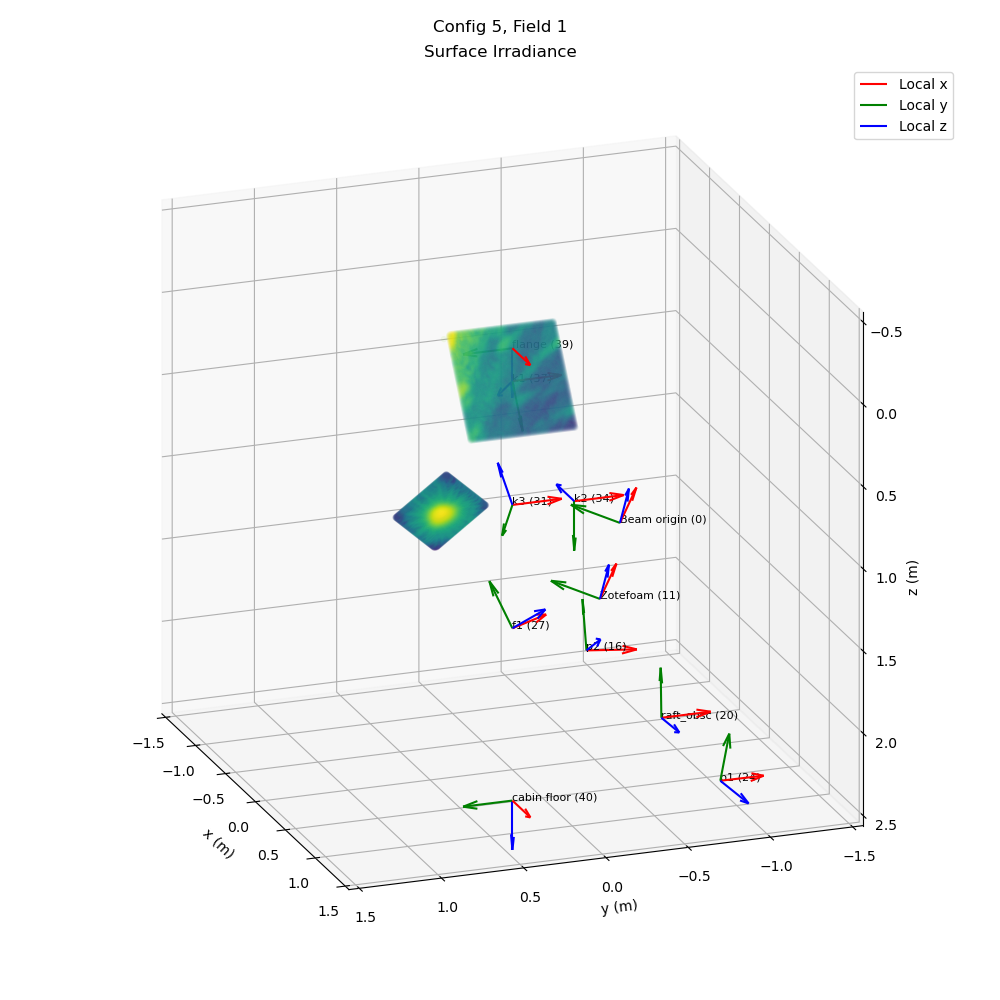

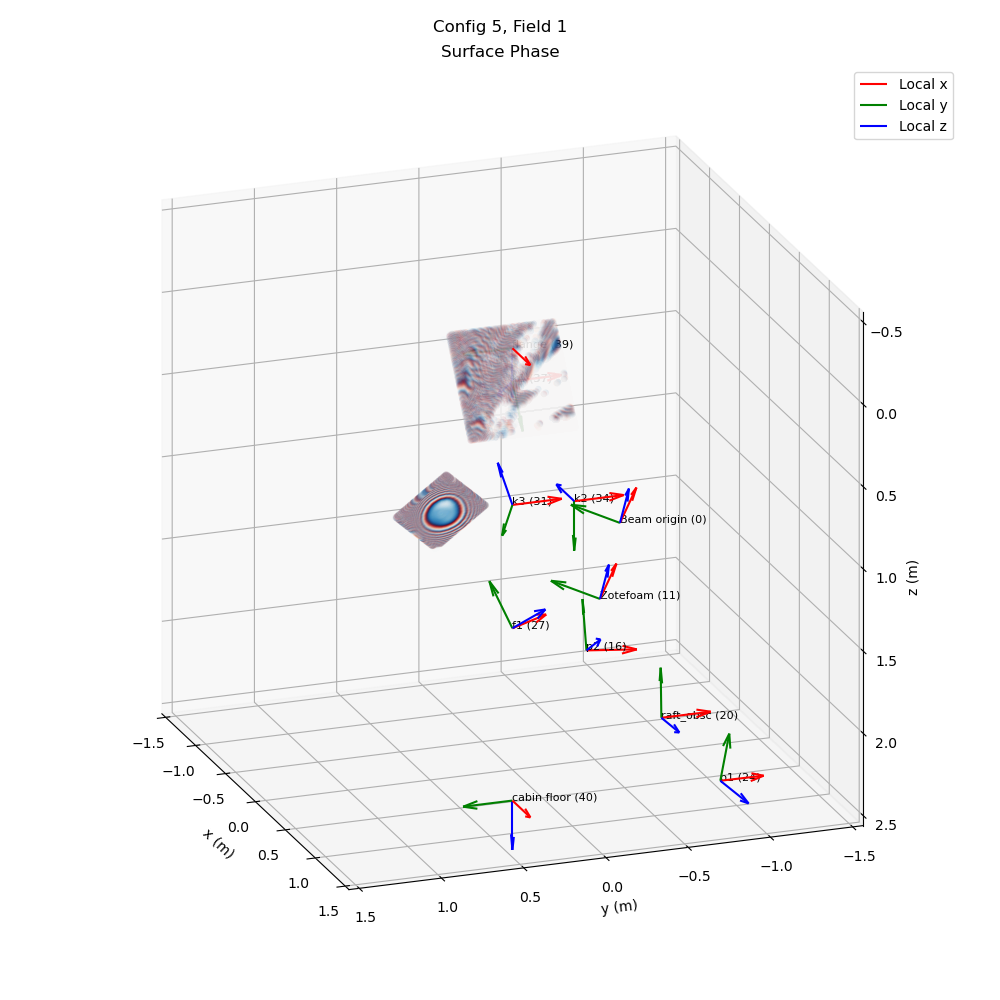

In [226]:
### Plot results

def mask_nans(arr):
    nan_mask = ~np.isnan(arr)
    return arr[nan_mask]

fig0, ax0 = plot_important_surfaces(global_matrices, surf_number_to_name)
stride = 4
ax0.scatter(
    src_prime_grid[::stride, ::stride, 0],
    src_prime_grid[::stride, ::stride, 1],
    src_prime_grid[::stride, ::stride, 2],
    c=mask_nans(np.log10(src[::stride,::stride])),
    edgecolor='none',
    alpha=0.1
)
ax0.scatter(
    dest_prime_grid[::stride, ::stride, 0],
    dest_prime_grid[::stride, ::stride, 1],
    dest_prime_grid[::stride, ::stride, 2],
    c=mask_nans(np.log10(intensity_grid[::stride,::stride])),
    edgecolor='none',
    alpha=0.1
)
ax0.set_title('Surface Irradiance')
fig0.suptitle(f'Config {config}, Field {field}')


fig1, ax1 = plot_important_surfaces(global_matrices, surf_number_to_name)
ax1.scatter(
    src_prime_grid[::stride, ::stride, 0],
    src_prime_grid[::stride, ::stride, 1],
    src_prime_grid[::stride, ::stride, 2],
    c=np.angle(src)[::stride,::stride],
    edgecolor='none',
    cmap='RdBu_r',
    alpha=0.1
)
ax1.scatter(
    dest_prime_grid[::stride, ::stride, 0],
    dest_prime_grid[::stride, ::stride, 1],
    dest_prime_grid[::stride, ::stride, 2],
    c=phase_grid[::stride,::stride],
    edgecolor='none',
    cmap='RdBu_r',
    alpha=0.1
)
ax1.set_title('Surface Phase')
fig1.suptitle(f'Config {config}, Field {field}')

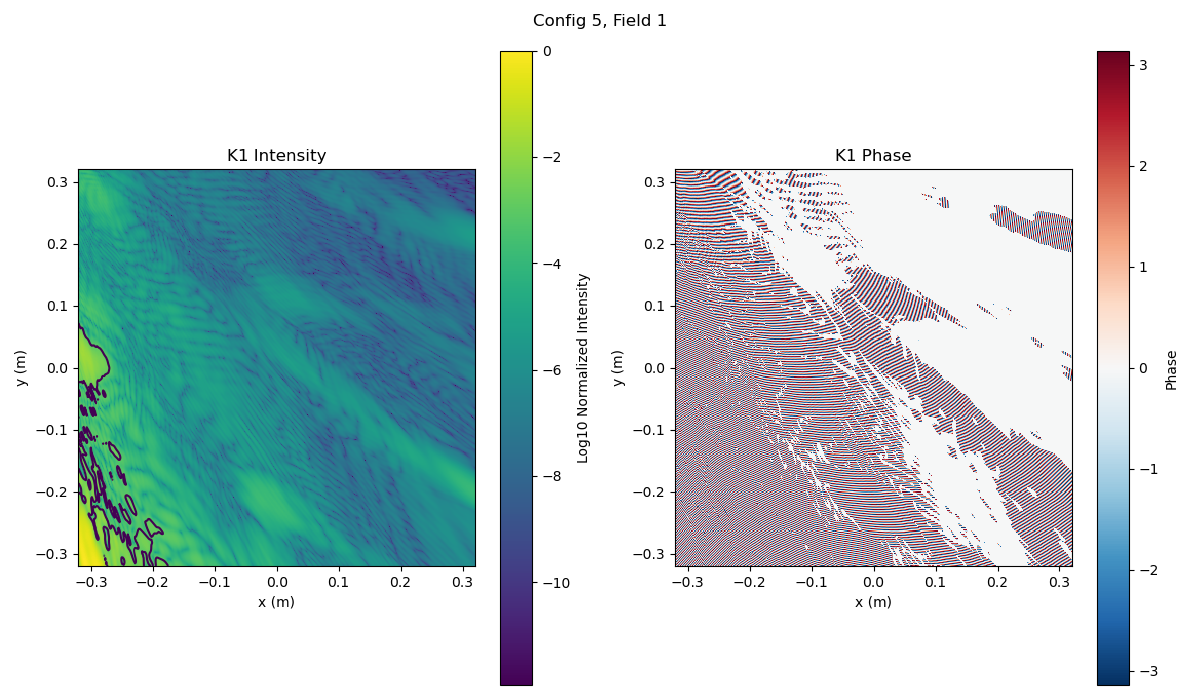

In [227]:
fig2, axs = plt.subplots(figsize=figsize, nrows=1, ncols=2)

stride = 1
im = axs[0].pcolormesh(
    xx_img[::stride, ::stride],
    yy_img[::stride, ::stride],
    np.log10(intensity_grid[::stride,::stride] / intensity_grid[::stride,::stride].max()),
)
axs[0].set_title(dest_surf_name.upper() + ' Intensity')
axs[0].contour(
    xx_img[::stride, ::stride],
    yy_img[::stride, ::stride],
    np.log10(intensity_grid[::stride,::stride] / intensity_grid[::stride,::stride].max()),
    levels=[-3]
)
plt.colorbar(im, ax=axs[0], label='Log10 Normalized Intensity')

im = axs[1].pcolormesh(
    xx_img[::stride, ::stride],
    yy_img[::stride, ::stride],
    phase_grid[::stride,::stride],
    cmap='RdBu_r',
)
axs[1].set_title(dest_surf_name.upper() + ' Phase')
plt.colorbar(im, ax=axs[1], label='Phase')

for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
fig2.suptitle(f'Config {config}, Field {field}')
fig2.tight_layout()

fig2.savefig(src_surf_name.upper() + '_to_' + dest_surf_name.upper() + f'_config_{config}_field_{field}_results.png', dpi=400)
# fig2.savefig('fresnel_zemax_test/' + 'arb_angle_results.png', dpi=400)

C:\Users\User\AppData\Local\Temp\ipykernel_10132\2234937128.py:9: UserWarning: The following kwargs were not used by contour: 'linecolor'
  axs[0].contour(xx_img[::stride, ::stride],


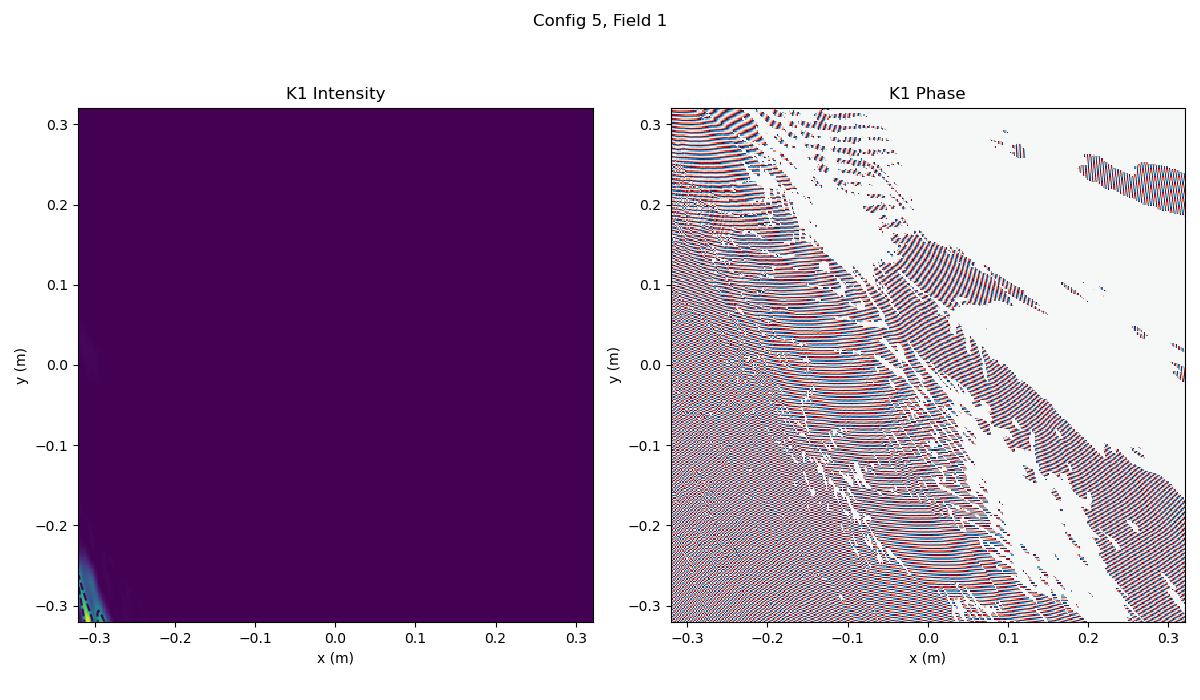

In [228]:
fig3, axs = plt.subplots(figsize=figsize, nrows=1, ncols=2)

stride = 1
axs[0].pcolormesh(
    xx_img[::stride, ::stride],
    yy_img[::stride, ::stride],
    intensity_grid[::stride,::stride],
)
axs[0].contour(xx_img[::stride, ::stride],
    yy_img[::stride, ::stride],
    intensity_grid[::stride,::stride],
    levels=[intensity_grid[::stride,::stride].max() / 2.],
    linecolor='w',
    linestyles='--'
)
axs[0].set_title(dest_surf_name.upper() + ' Intensity')
axs[1].pcolormesh(
    xx_img[::stride, ::stride],
    yy_img[::stride, ::stride],
    phase_grid[::stride,::stride],
    cmap='RdBu_r',
)
axs[1].set_title(dest_surf_name.upper() + ' Phase')
for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
fig3.suptitle(f'Config {config}, Field {field}')
fig3.tight_layout()

fig3.savefig(src_surf_name.upper() + '_to_' + dest_surf_name.upper() + f'_config_{config}_field_{field}_results_nonlog.png', dpi=400)
# fig3.savefig('fresnel_zemax_test/' + 'arb_angle_results_nonlog.png', dpi=400)

In [229]:
# from matplotlib import animation

# fig0, ax0 = plot_important_surfaces(global_matrices, surf_number_to_name)

# def init():
#     stride = 3
#     ax0.scatter(
#         src_prime_grid[::stride, ::stride, 0],
#         src_prime_grid[::stride, ::stride, 1],
#         src_prime_grid[::stride, ::stride, 2],
#         c=mask_nans(np.log10(src[::stride,::stride])),
#         edgecolor='none',
#         alpha=0.5
#     )
#     ax0.scatter(
#         dest_prime_grid[::stride, ::stride, 0],
#         dest_prime_grid[::stride, ::stride, 1],
#         dest_prime_grid[::stride, ::stride, 2],
#         c=mask_nans(np.log10(intensity_grid[::stride,::stride])),
#         edgecolor='none',
#         alpha=0.5
#     )
#     ax0.set_title('Surface Irradiance')
#     return fig0,


# # https://stackoverflow.com/a/18345457
# def animate(i):
#     ax0.view_init(elev=-160., azim=2*i)
#     return fig0,

# anim = animation.FuncAnimation(fig0, animate, init_func=init,
#                                frames=180, interval=200, blit=True)
# writergif = animation.PillowWriter(fps=15)
# anim.save(src_surf_name.upper() + '_to_' + dest_surf_name.upper() + f'_config_{config}_field_{field}_results.gif', writer=writergif)